In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
from tqdm import tqdm, trange, tqdm_notebook
import re
import nltk
from multiprocessing import cpu_count, Pool
from functools import partial
import ipywidgets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from rewrite.scorer import score_4class
import utils # utils from CS224U
from scipy.spatial import distance
import random
tqdm.pandas()
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment import vader

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/home/gui/anaconda3/envs/nlu4/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def del_str_cols(df): # df should be X, e.g. X_train or X_dev
    try:
        del df["articleBody"]
    except:
        pass
    try:
        del df["Headline"]
    except:
        pass
    try:
        del df["Body ID"]
    except:
        pass
    for col_name in df.columns:
        if "___" == col_name[0:3]:
            del df[col_name]
            
def print_reports(preds, actual):
    print(classification_report(actual, preds))
    score, max_score = score_4class(actual, preds)
    print("Weighted accuracy: "+str(score/max_score)+" ("+str(score)+" out of "+str(max_score)+")")

def print_feature_importances(model, df):
    feat_imp = model.feature_importances_
    indices = np.argsort(feat_imp)[::-1]
    for ii in indices:
        print(df.columns[ii]+": "+str(feat_imp[ii]))
        
# Usage: pass Xy_train (or a df with Body ID col., and y col. as well)
# returns the same format of df, but spplit so that no body ID is shared between sets
proportion_for_holdout_dev_set = 0.2
def disjoint_train_test_split(Xy, frac_for_test_set=proportion_for_holdout_dev_set, random_state=42):
    r = random.Random()
    r.seed(random_state)
    Xy_IDs = list(set(Xy["Body ID"]))
    print("Total unique IDs: "+str(len(Xy_IDs)))
    r.shuffle(Xy_IDs)
    num_IDs_for_train = int((1-frac_for_test_set)*len(Xy_IDs))
    train_IDs = Xy_IDs[:num_IDs_for_train]
    test_IDs = Xy_IDs[num_IDs_for_train:]
    train_df = Xy[Xy["Body ID"].isin(train_IDs)]
    test_df = Xy[Xy["Body ID"].isin(test_IDs)]
    print("# instances in train: "+str(train_df.shape[0]))
    print("# instances in test: "+str(test_df.shape[0]))
    assert len(set(train_df["Body ID"].unique()) & set(test_df["Body ID"].unique())) == 0 # totally disjoint
    return train_df, test_df

In [3]:
from multiprocessing import cpu_count, Pool
cores = cpu_count() 
partitions = cores
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

In [4]:
##### ADD OUR FEATURES
# START SENTIMENT ANALYSIS
def vader_pol_helper(df):
    return df.apply(lambda hl: pd.Series(sid.polarity_scores(hl)))
sid = vader.SentimentIntensityAnalyzer() # global scope for parallelization
def add_vader_sent(X_df):
    def vader_polarity_scores(df, text_col_name, col_name_prefix):
        pol_scores = parallelize(df[text_col_name], vader_pol_helper)
        #pol_scores = df[text_col_name].progress_apply(lambda hl: pd.Series(sid.polarity_scores(hl)))
        cols = pol_scores.columns
        new_cols = []
        for col_name in cols:
            new_cols.append("vader_"+col_name_prefix+"_"+col_name)
        pol_scores.columns = new_cols
        return pol_scores

    vader_hl_df = vader_polarity_scores(X_df, "Headline", "hl")
    vader_body_df = vader_polarity_scores(X_df, "articleBody", "body")
    X_df = pd.concat([X_df, vader_hl_df, vader_body_df], axis=1)
    return X_df

# END SENTIMENT ANALYSIS
### GLOVE ####
glove_dim = 200
glove_src = os.path.join("GloVe", 'glove.6B.'+str(glove_dim)+'d.txt')
GLOVE = utils.glove2dict(glove_src)
def text_to_mean_vec_ignore_unk(text, w2v=GLOVE, dim=glove_dim):
    vec = np.zeros(dim)
    num_added = 0
    for word in text:
        if word in w2v:
            vec += w2v[word]
            num_added += 1
    if num_added > 0:
        return vec/num_added
    else:
        return np.array([random.uniform(-0.5, 0.5) for i in range(glove_dim)])
def get_glove_cos_dist_hl_body(row):
    hl = row["___clean_headline_tokenized_lemmas"]
    body = row["___clean_body_tokenized_lemmas"]
    hl_vec = text_to_mean_vec_ignore_unk(hl)
    body_vec = text_to_mean_vec_ignore_unk(body)
    cosine_dist = distance.cosine(hl_vec, body_vec) # cosine() from scipy
    return cosine_dist

def get_verbs(text):
    verbs = [token for token, pos in nltk.pos_tag(text) if pos.startswith('VB')]
    verbs_sentence = ' '.join(word[0] for word in verbs)
    return verbs_sentence
 
def get_verb_glove_cos_dist_hl_body(row):
    hl = row["___clean_headline_tokenized_lemmas"]
    body = row["___clean_body_tokenized_lemmas"]
    
    hl_verbs = get_verbs(hl)
    body_verbs = get_verbs(body)
    
    hl_vec = text_to_mean_vec_ignore_unk(hl_verbs)
    body_vec = text_to_mean_vec_ignore_unk(body_verbs)
    cosine_dist = distance.cosine(hl_vec, body_vec) # cosine() from scipy
    return cosine_dist

def hl_body_glove_cos_dist_helper(X_df):
    return X_df[["___clean_headline_tokenized_lemmas", "___clean_body_tokenized_lemmas"]].apply(get_glove_cos_dist_hl_body, axis=1)

def hl_body_glove_verb_helper(X_df):
    return X_df[["___clean_headline_tokenized_lemmas", "___clean_body_tokenized_lemmas"]].apply(get_verb_glove_cos_dist_hl_body, axis=1)

### END GLOVE CODE BLOCK
def add_all_features(X_df, parallel=True):
    print("Adding glove feature #1...", flush=True)
    X_df["hl_body_glove_"+str(glove_dim)+"_cos_dist"] = parallelize(X_df, hl_body_glove_cos_dist_helper)
    print("Adding glove feature #2...", flush=True)
    X_df["hl_body_verb_glove_"+str(glove_dim)+"_cos_dist"] = parallelize(X_df, hl_body_glove_verb_helper)
    print("Adding VADER sentiment...", flush=True)
    X_df = add_vader_sent(X_df)
    return X_df

In [ ]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")

X_test = pd.read_hdf("X_TEST-allfeatures.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")



In [ ]:
%time X_train = add_all_features(X_train)
%time X_dev = add_all_features(X_dev)
%time X_test = add_all_features(X_test)

In [ ]:
X_train.to_hdf('X_train_disjoint-allfeatures-2.h5','df')
X_dev.to_hdf('X_dev_disjoint-allfeatures-2.h5','df')
X_test.to_hdf('X_TEST-allfeatures-2.h5','df')

In [ ]:
---------

In [53]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_train = y_train["Stance"]

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_dev = y_dev["Stance"]
del_str_cols(X_dev)

X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")
y_test = y_test["Stance"]
del_str_cols(X_test)


In [54]:
# Step 1 -- turn into 1/2 sets
def prep_2step_sets(X_train, y_train):
    Xy_train = pd.concat([X_train, y_train], axis=1)

    Xy_train_1 = Xy_train.copy()
    Xy_train_1.loc[Xy_train_1["Stance"] != "unrelated", 'Stance'] = "related"
    y_train_1 = Xy_train_1["Stance"]
    X_train_1 = Xy_train_1.drop(["Stance"], axis=1)

    Xy_train_2 = Xy_train[Xy_train["Stance"] != "unrelated"]
    y_train_2 = Xy_train_2["Stance"]
    X_train_2 = Xy_train_2.drop("Stance", axis=1)

    del_str_cols(X_train_1)
    del_str_cols(X_train_2)
    
    return X_train_1, y_train_1, X_train_2, y_train_2

In [55]:
X_train_1, y_train_1, X_train_2, y_train_2 = prep_2step_sets(X_train, y_train)

In [56]:
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)

(39437, 53)
(39437,)
(10629, 53)
(10629,)


In [60]:
## CLASSIFIER 1 - RELATED/UNRELATED
#mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod1 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod1.fit(X_train_1, y_train_1)

## CLASSIFIER 2 - 3-class
#mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod2 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod2.fit(X_train_2, y_train_2)

      Iter       Train Loss   Remaining Time 
         1           1.0238           11.06s
         2           0.9178           11.01s
         3           0.8338           10.81s
         4           0.7654           10.61s
         5           0.7080           10.95s
         6           0.6587           10.78s
         7           0.6170           10.64s
         8           0.5811           10.71s
         9           0.5483           10.67s
        10           0.5207           10.58s
        20           0.3673            9.92s
        30           0.3109            9.79s
        40           0.2788            9.26s
        50           0.2608            8.51s
        60           0.2479            7.90s
        70           0.2393            7.17s
        80           0.2320            6.57s
        90           0.2258            5.96s
       100           0.2206            5.38s
       200           0.1851            0.00s
      Iter       Train Loss   Remaining Time 
        

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [61]:
def predict_tsm(mod1, mod2, X):
        #if X is None:
        #    X = self.X_dev_1
        del_str_cols(X)
        preds_1 = mod1.predict(X)
        preds_2 = mod2.predict(X) # note X_dev_1
        
        new_preds = preds_1.copy()
        for ii in range(preds_1.shape[0]):
            if preds_1[ii] == "related":
                new_preds[ii] = preds_2[ii]
            else:
                new_preds[ii] = "unrelated"
        return new_preds

In [62]:
preds_rf_test = predict_tsm(mod1, mod2, X_test) # actually GBTs
print_reports(preds_rf_test, y_test)

             precision    recall  f1-score   support

      agree       0.41      0.21      0.28      1903
   disagree       0.22      0.01      0.01       697
    discuss       0.62      0.77      0.68      4464
  unrelated       0.95      0.97      0.96     18349

avg / total       0.83      0.85      0.83     25413

Weighted accuracy: 0.7603046883381611 (8858.5 out of 11651.25)


In [59]:
preds_rf_test = predict_tsm(mod1, mod2, X_test)
print_reports(preds_rf_test, y_test)

             precision    recall  f1-score   support

      agree       0.44      0.18      0.25      1903
   disagree       0.00      0.00      0.00       697
    discuss       0.62      0.78      0.69      4464
  unrelated       0.94      0.98      0.96     18349

avg / total       0.82      0.86      0.83     25413

Weighted accuracy: 0.7588456174230233 (8841.5 out of 11651.25)


/home/gui/anaconda3/envs/nlu4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
----

In [43]:
preds_rf = predict_tsm(mod1, mod2, X_dev)

In [44]:
# RFs
print_reports(preds_rf, y_dev)

             precision    recall  f1-score   support

      agree       0.60      0.26      0.36       784
   disagree       1.00      0.07      0.13       209
    discuss       0.65      0.85      0.73      1805
  unrelated       0.97      0.98      0.97      7737

avg / total       0.88      0.88      0.87     10535

Weighted accuracy: 0.8090760209202811 (3828.75 out of 4732.25)


In [31]:
# GBTs:
print_reports(preds, y_dev)

             precision    recall  f1-score   support

      agree       0.51      0.24      0.32       784
   disagree       0.30      0.01      0.03       209
    discuss       0.64      0.84      0.73      1805
  unrelated       0.97      0.98      0.97      7737

avg / total       0.87      0.88      0.86     10535

Weighted accuracy: 0.8044270695757831 (3806.75 out of 4732.25)


In [32]:
#mod_one = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod_one = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)

In [33]:
del_str_cols(X_train)

In [34]:
mod_one.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       38536.1616            1.82m
         2       34452.7665            1.82m
         3       31155.7738            1.76m
         4       28454.5056            1.73m
         5       26224.7660            1.71m
         6       24357.8561            1.69m
         7       22789.9342            1.67m
         8       21469.7664            1.65m
         9       20336.3581            1.65m
        10       19386.5215            1.64m
        20       14712.6815            1.56m
        30       13239.1760            1.45m
        40       12549.6913            1.35m
        50       12071.9573            1.25m
        60       11714.0419            1.16m
        70       11437.0315            1.06m
        80       11196.0321           58.36s
        90       10966.1043           53.11s
       100       10757.8354           48.08s
       200        9280.4048            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [21]:
# RFs:
preds_one = mod_one.predict(X_dev)
print_reports(preds, y_dev)

             precision    recall  f1-score   support

      agree       0.60      0.26      0.36       784
   disagree       1.00      0.07      0.13       209
    discuss       0.65      0.85      0.73      1805
  unrelated       0.97      0.98      0.97      7737

avg / total       0.88      0.88      0.87     10535

Weighted accuracy: 0.8090760209202811 (3828.75 out of 4732.25)


In [35]:
# GBTs:
preds_one = mod_one.predict(X_dev)
print_reports(preds, y_dev)

             precision    recall  f1-score   support

      agree       0.51      0.24      0.32       784
   disagree       0.30      0.01      0.03       209
    discuss       0.64      0.84      0.73      1805
  unrelated       0.97      0.98      0.97      7737

avg / total       0.87      0.88      0.86     10535

Weighted accuracy: 0.8044270695757831 (3806.75 out of 4732.25)


Confusion matrix, without normalization
[[ 205    0  503   76]
 [  27   15  150   17]
 [  99    0 1528  178]
 [  12    0  181 7544]]
Normalized confusion matrix
[[0.26 0.   0.64 0.1 ]
 [0.13 0.07 0.72 0.08]
 [0.05 0.   0.85 0.1 ]
 [0.   0.   0.02 0.98]]


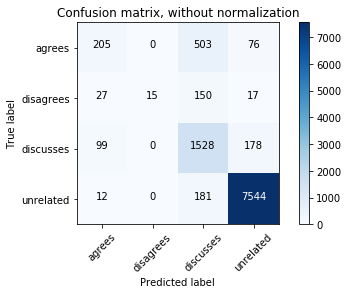

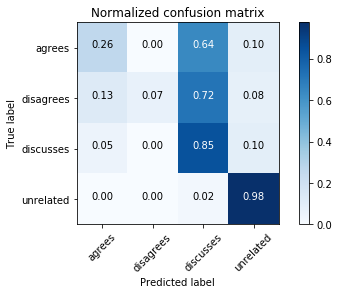

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_dev, preds_rf)
class_names = ["agrees", "disagrees", "discusses", "unrelated"]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
----

In [ ]:
crf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)

In [ ]:
crf.fit(X_train, y_train)

In [ ]:
preds = crf.predict(X_dev)
print(classification_report(y_dev, preds))

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, preds, labels=["agree", "disagree", "discuss"], sample_weight=None)